# 프로젝트: 뉴스기사 요약해보기

## 목차
 - Step 1. 데이터 수집하기
 - Step 2. 데이터 전처리하기 (추상적 요약)
 - Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
 - Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
 - Step 5. Summa을 이용해서 추출적 요약해보기
---

## Step 1. 데이터 수집하기

In [1]:
import nltk
import tensorflow
import summa
import pandas as pd
import numpy as np
import urllib.request
import re

from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm


In [2]:
# 데이터 수집
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
40309,Teaser of 'Laila Majnu' presented by Imtiaz Al...,"The teaser of the upcoming film 'Laila Majnu',..."
35068,Sketch of man who warned pornstar over Trump a...,Pornstar Stormy Daniels on Tuesday released a ...
250,Sonam Kapoor to join cast for 'Munna Bhai 3': ...,Actress Sonam Kapoor will star in the third in...
18586,"Asiad gold no fluke, can beat Olympic champ ag...","Boxer Amit Panghal, who won a gold at the Asia..."
9115,Man suffers permanent hearing loss after ear-b...,"Mukesh Sharma, a passenger who suffered ear-bl..."
3031,Man kills wife's brother to get her sympathy v...,Punjab Police has arrested a 47-year-old man f...
26795,"Development doesn't bring votes, Hindutva to h...","BJP MP Subramanian Swamy has said, ""Economic d..."
15445,Another Chinese space station set to fall to E...,China is planning to bring its second space la...
64275,11-year-old foreigner raped in Noida school fo...,A Greater Noida school official has been arres...
89913,Bus stop made of used plastic bottles created ...,"A bus stop made using 1,000 plastic bottles of..."


In [4]:
print(len(data))

98401


## Step 2. 데이터 전처리하기 (추상적 요약)

In [5]:
# 중복되는 값 확인 및 제거
print('# of items in "text":', data['text'].nunique())
print('# of items in "headlines":', data['headlines'].nunique())

# of items in "text": 98360
# of items in "headlines": 98280


In [6]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('total number of items:', len(data))

total number of items: 98360


In [7]:
# 결측치 확인 및 제거
data.isna().sum()

headlines    0
text         0
dtype: int64

In [8]:
# 텍스트 정규화 사전 정의
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [9]:
# 불용어 사전 불러오기
nltk.download('stopwords')
stopwords.words('english')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [10]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
# 전체 text 데이터에 대한 전처리
clean_text = []

for sentence_text in tqdm(data['text']):
    clean_text.append(preprocess_sentence(sentence_text))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

100%|██████████| 98360/98360 [09:35<00:00, 170.77it/s]

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [12]:
# 전체 headline 데이터에 대한 전처리
clean_headline = []

for sentence_head in tqdm(data['headlines']):
    clean_headline.append(preprocess_sentence(sentence_head, remove_stopwords=False))

# 전처리 후 출력
print("headline 전처리 후 결과: ", clean_headline[:5])

100%|██████████| 98360/98360 [00:17<00:00, 5709.38it/s]

headline 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [13]:
# 전처리 데이터로 기존 데이터 대치 후 결과 확인
data['text'] = clean_text
data['headlines'] = clean_headline

data.replace('', np.nan, inplace=True) # 빈 값을 Null 값으로 변환
data.isnull().sum()

headlines    0
text         0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


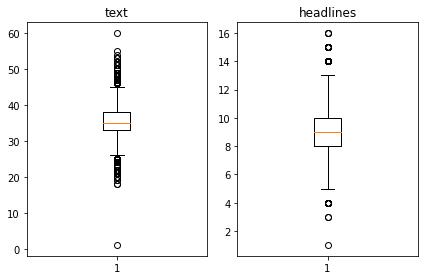

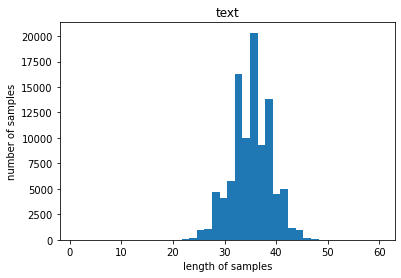

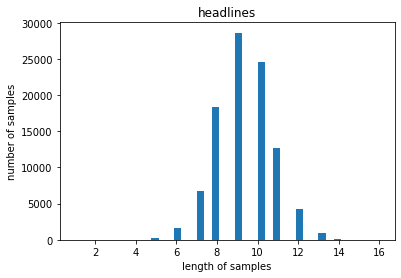

In [14]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
head_len = [len(s.split()) for s in data['headlines']]

print(f'텍스트의 최소 길이 : {np.min(text_len)}')
print(f'텍스트의 최대 길이 : {np.max(text_len)}')
print(f'텍스트의 평균 길이 : {np.mean(text_len)}')
print(f'요약의 최소 길이 : {np.min(head_len)}')
print(f'요약의 최대 길이 : {np.max(head_len)}')
print(f'요약의 평균 길이 : {np.mean(head_len)}')

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(head_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(head_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
text_max_len = 38
head_max_len = 10

In [16]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))


In [17]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(head_max_len, data['headlines'])

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.8163379422529483
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


In [18]:
# 최대 길이를 넘는 데이터 제거

data['text_include'] = data['text'].apply(lambda t: len(t.split()) <= text_max_len)
data['head_include'] = data['headlines'].apply(lambda s: len(s.split()) <= head_max_len)
data['include'] = data.all(axis=1, bool_only=True)

data = data[['headlines', 'text']].loc[data['include']==True]

In [19]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [20]:
# 데이터 셔플 및 분리
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

train_test_ratio = 0.2 # train set과 test set의  비율
num_of_test = int(len(encoder_input)*train_test_ratio)

encoder_input_train = encoder_input[:-num_of_test]
decoder_input_train = decoder_input[:-num_of_test]
decoder_target_train = decoder_target[:-num_of_test]

encoder_input_test = encoder_input[-num_of_test:]
decoder_input_test = decoder_input[-num_of_test:]
decoder_target_test = decoder_target[-num_of_test:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52236
훈련 레이블의 개수 : 52236
테스트 데이터의 개수 : 13059
테스트 레이블의 개수 : 13059


In [21]:
# 단어 집합 만들기

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [22]:
# 빈도수 적은 단어 제거

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 57241
등장 빈도가 6번 이하인 희귀 단어의 수: 39345
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17896
단어 집합에서 희귀 단어의 비율: 68.73569644136197
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.516019067335055


In [23]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [24]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 샘플 출력
print(encoder_input_train[:3])

[[1650, 4494, 1057, 5921, 1, 478, 1674, 21432, 4610, 7211, 3163, 86, 689, 7693, 10357, 3752, 6682, 1708, 601, 689, 1928, 10358, 91, 28, 2, 5921, 84, 3090, 1518, 982, 686, 25, 2406, 966, 1708, 689], [45, 1399, 168, 64, 76, 359, 358, 3046, 183, 1118, 168, 2798, 168, 700, 12590, 676, 66, 4163, 676, 861, 302, 1626, 509, 444, 467, 1118, 5169, 2467, 89, 1953, 1770, 100, 1424, 375], [6023, 879, 127, 669, 1400, 343, 628, 1881, 516, 1881, 2230, 2687, 1526, 343, 215, 9714, 127, 1, 61, 127, 669, 628, 1881, 1267, 3288, 4122, 297, 1035, 825, 3288]]


In [25]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [26]:
# 빈도수 적은 단어 제거

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 25872
등장 빈도가 5번 이하인 희귀 단어의 수: 17467
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8405
단어 집합에서 희귀 단어의 비율: 67.51314162028447
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.495355313638046


In [27]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print(decoder_input_train[:5])
print('target')
print(decoder_target_train[:5])

input
[[1, 15, 193, 3, 402, 8, 5993, 840], [1, 667, 328, 87, 2446, 208, 8, 467, 328], [1, 130, 2929, 1976, 395, 2087, 2571, 3], [1, 54, 3013, 104, 1052, 4, 1439, 4, 25, 93, 1328], [1, 8407, 4103, 88, 45, 993, 14, 535, 543]]
target
[[15, 193, 3, 402, 8, 5993, 840, 2], [667, 328, 87, 2446, 208, 8, 467, 328, 2], [130, 2929, 1976, 395, 2087, 2571, 3, 2], [54, 3013, 104, 1052, 4, 1439, 4, 25, 93, 1328, 2], [8407, 4103, 88, 45, 993, 14, 535, 543, 2]]


In [28]:
# 빈도수 낮은 단어 제거 후 길이가 0이 된 데이터 제거

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 52236
훈련 레이블의 개수 : 52236
테스트 데이터의 개수 : 13059
테스트 레이블의 개수 : 13059


In [29]:
# 전체 데이터에 대해 패딩

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=head_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=head_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=head_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=head_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

In [43]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 
embedding_dim = 128
hidden_size_1 = 256
hidden_size_2 = 256
hidden_size_3 = 256
hidden_size_4 = 256
hidden_size_dec = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM
encoder_lstm1 = LSTM(hidden_size_1, return_sequences=True, return_state=True, dropout=0.4)(enc_emb)
encoder_lstm2 = LSTM(hidden_size_2, return_sequences=True, return_state=True, dropout=0.4)(encoder_lstm1)
encoder_lstm3 = LSTM(hidden_size_3, return_sequences=True, return_state=True, dropout=0.4)(encoder_lstm2)
encoder_lstm4 = LSTM(hidden_size_4, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm4(encoder_lstm3)

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size_dec, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 38, 128)      2816000     input_8[0][0]                    
__________________________________________________________________________________________________
lstm_10 (LSTM)                  [(None, 38, 256), (N 394240      embedding_4[0][0]                
__________________________________________________________________________________________________
lstm_11 (LSTM)                  [(None, 38, 256), (N 525312      lstm_10[0][0]                    
                                                                 lstm_10[0][1]              

In [44]:
# 모델 훈련하기

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
205/205 [==============================] - 27s 102ms/step - loss: 6.4655 - val_loss: 6.0966
Epoch 2/50
205/205 [==============================] - 20s 99ms/step - loss: 6.0195 - val_loss: 5.8498
Epoch 3/50
205/205 [==============================] - 20s 99ms/step - loss: 5.7930 - val_loss: 5.6878
Epoch 4/50
205/205 [==============================] - 20s 97ms/step - loss: 5.5309 - val_loss: 5.4543
Epoch 5/50
205/205 [==============================] - 20s 97ms/step - loss: 5.2576 - val_loss: 5.2434
Epoch 6/50
205/205 [==============================] - 20s 98ms/step - loss: 5.0225 - val_loss: 5.0444
Epoch 7/50
205/205 [==============================] - 20s 98ms/step - loss: 4.8319 - val_loss: 5.0246
Epoch 8/50
205/205 [==============================] - 20s 98ms/step - loss: 4.6675 - val_loss: 4.8885
Epoch 9/50
205/205 [==============================] - 20s 98ms/step - loss: 4.5219 - val_loss: 4.8083
Epoch 10/50
205/205 [==============================] - 20s 98ms/step - loss: 4.38

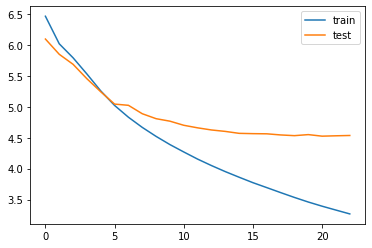

In [45]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [46]:
# 정수 인덱스 <-> 단어 변환 사전
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [47]:
# 추론 모델 설계
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size_dec,))
decoder_state_input_c = Input(shape=(hidden_size_dec,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size_dec))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])



In [48]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (head_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [49]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0) and tar_index_to_word[i] not in ['sostoken', 'eostoken']:
            temp = temp + tar_index_to_word[i]+' '
    return temp


In [50]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : snapdeal started initiating payouts around employees fired february year layoffs announced snapdeal founders rohit bansal kunal bahl committed take pay cut commerce startup reserved shareholding esops value dipped past months 
실제 요약 : snapdeal to people fired in february 
예측 요약 :  snapdeal denies probe into snapdeal merger


원문 : emergency exit door nigerian airline plane fell shortly aircraft landed nigerian capital city denying mechanical issue responsible dana air said door could fallen without conscious effort passenger open passengers however reportedly denied tampering door 
실제 요약 : airline blames fliers as emergency door falls after landing 
예측 요약 :  plane crashes into plane crashes into planes in


원문 : russia reportedly preparing test tonne intercontinental ballistic missile codenamed capable destroying whole uk france missile deliver dozen nuclear warheads times powerful atom bombs dropped hiroshima nagasaki 
실제 요약 : russia to test missile capable of destroying entire uk

예측 요약 :  jnu to observe quota from darjeeling


원문 : designer sabyasachi mukherjee slammed shaming indian women know wear saree sabyasachi telling indian women wear saree classic example user commented one man telling women read tweet another user wrote women know saree 
실제 요약 : sabyasachi slammed for shaming women not saree 
예측 요약 :  twitter reacts to swara on twitter


원문 : congress president rahul gandhi winked fellow mps following hug prime minister narendra modi friday lok sabha speaker sumitra mahajan said winking dignity parliament pm narendra modi seat commands respect oppose hugging hugging wink proper added 
실제 요약 : is against the dignity of parliament ls speaker 
예측 요약 :  rahul gandhi calls pm modi for corruption


원문 : congress leader kapil sibal saturday tweeted saying moody upgradation india sovereign rating contrast mood people tweeted moody talks sunshine tomorrow worried dark clouds today comes credit rating agency moody upgraded india sovereign rating lowest investmen

예측 요약 :  george clooney khan passes away at


원문 : uttar pradesh government decided withdraw seven year old rape case bjp leader former union minister swami booked allegedly abducting raping woman ashram threatening complaining however reason provided state government withdrawing complaint 
실제 요약 : up government to withdraw rape case against bjp leader 
예측 요약 :  bjp mla booked for raping woman in rape case


원문 : first year female mbbs student private medical college filed police complaint alleging rape peon college campus odisha bhubaneswar refuting allegations accused said instead seen girl male friend compromising position campus peon added went room incident 
실제 요약 : mbbs student alleges rape by on odisha college campus 
예측 요약 :  kerala school teacher arrested for sexually abusing minor girl




## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
### 좋은 요약 예시

### 어색한 요약 예시
- 원문 : emergency exit door nigerian airline plane fell shortly aircraft landed nigerian capital city denying mechanical issue responsible dana air said door could fallen without conscious effort passenger open passengers however reportedly denied tampering door 
    - 실제 요약 : airline blames fliers as emergency door falls after landing 
    - 예측 요약 :  plane crashes into plane crashes into planes in
- 원문 : siberia based airlines teamed russia bank issue passenger tickets blockchain implementation ethereum blockchain based platform aims reduce settlement time airline agent seconds around weeks airline reportedly already used new blockchain based system sell tickets 
    - 실제 요약 : russia airline sells tickets using blockchain based system 
    - 예측 요약 :  us to buy electric cars for crore


## Step 5. Summa을 이용해서 추출적 요약해보기

In [51]:
from summa.summarizer import summarize

In [56]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 (추상적) :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("예측 요약 (추출적) :", summarize(seq2text(encoder_input_test[i]), words=5))
    print("\n")

원문 : snapdeal started initiating payouts around employees fired february year layoffs announced snapdeal founders rohit bansal kunal bahl committed take pay cut commerce startup reserved shareholding esops value dipped past months 
실제 요약 : snapdeal to people fired in february 
예측 요약 (추상적) :  snapdeal denies probe into snapdeal merger
예측 요약 (추출적) : 


원문 : emergency exit door nigerian airline plane fell shortly aircraft landed nigerian capital city denying mechanical issue responsible dana air said door could fallen without conscious effort passenger open passengers however reportedly denied tampering door 
실제 요약 : airline blames fliers as emergency door falls after landing 
예측 요약 (추상적) :  plane crashes into plane crashes into planes in
예측 요약 (추출적) : 


원문 : russia reportedly preparing test tonne intercontinental ballistic missile codenamed capable destroying whole uk france missile deliver dozen nuclear warheads times powerful atom bombs dropped hiroshima nagasaki 
실제 요약 : russia to te

예측 요약 (추상적) :  uber recalls self driving cars in car crash
예측 요약 (추출적) : 


원문 : spicejet successfully completed india first ever powered test flight monday airline flew bombardier aircraft using aviation turbine fuel fuel dehradun new delhi around people including officials aviation regulator spicejet onboard test flight lasted around minutes 
실제 요약 : spicejet successfully india st powered flight 
예측 요약 (추상적) :  flights to get flights from flights to
예측 요약 (추출적) : 


원문 : vice chancellor allahabad university reportedly submitted proposal rename university prayagraj state university proposal currently pending approval uttar pradesh government following sent office governor clearance october uttar pradesh government officially renamed allahabad prayagraj 
실제 요약 : allahabad university likely to be renamed as prayagraj university 
예측 요약 (추상적) :  jnu to observe quota from darjeeling
예측 요약 (추출적) : 


원문 : designer sabyasachi mukherjee slammed shaming indian women know wear saree sabyasachi 

예측 요약 (추상적) :  cbfc should not be used for films hansal
예측 요약 (추출적) : 


원문 : ousted censor board chief pahlaj nihalani said former minister state information broadcasting rajyavardhan singh rathore made look like villain pahlaj said though rajyavardhan approved way working yet would project completely different image met actors filmmakers 
실제 요약 : made me look like villain pahlaj 
예측 요약 (추상적) :  cbfc chief pahlaj gets new cbfc chief
예측 요약 (추출적) : 


원문 : state bank india monday hiked fixed deposit interest rates select crore year years provide interest earlier senior citizens get deposits years years interest rate revised 
실제 요약 : sbi raises fixed deposit interest rates 
예측 요약 (추상적) :  govt to pay crore to gst for gst
예측 요약 (추출적) : 


원문 : tesla ceo elon musk fortune dropped billion friday day securities exchange commission accused misleading investors tweets taking carmaker private shares company fell friday regulator seeking ban musk worth billion serving director officer 
실제 요약 : e

In [74]:
summarize('supreme court judge justice chelameswar turned sc bar association invite attend farewell function citing personal reasons justice chelameswar retiring june may last working day court farewell function retiring judge sc final working day ', words=8)

''

추출적 요약이 작동하지 않는다...

## 회고
- 이번 프로젝트는 다음과 같은 과정으로 이루어졌다.
    - 텍스트 데이터 불러오기(기사와 그 요약)
    - 데이터 전처리(정규화 및 불용어 제거, 텍스트 최대 길이 설정, 시작/종료 토큰 추가, 단어 사전 설정 등)
    - 어텐션 메커니즘을 사용한 seq2seq 모델 설계(훈련용 모델과 추론용 모델 별도)
    - 학습 및 결과 확인
- 데이터 전처리 자체는 노드 내용을 참고하여 어렵지 않게 진행할 수 있었다. 문제는 적절한 모델을 설계하는 것이다. 인코더에서는 LSTM 3개를 이용한 모델과 4개를 이용한 모델을 사용해봤는데 성능의 차이를 체감하기는 어려웠다. 모델이 예측한 요약문은 문법적으로도 의미적으로도 어색한 경우가 대부분이었다. 어떤 부분을 고쳐야 성능 상의 유의미한 차이가 있을지 감이 오지 않았다. seq2seq 모델에 대해 더 공부가 필요할 것 같다.
- 추출적 요약이 제대로 작동하지 않았는데, 입력 데이터가 충분히 길지 않아서 그런 것이 아닐까 싶다.